# Deep LPBM: Testing on Real-world dataset
**Introduction to Probabilistic Graphical Models and Deep Generative Models (MVA 2025-2026)**  

**Student:** Karina Musina
**Email:** karina.musina@student-cs.fr
**Student:** Yannaël Bossard
**Email:** yannael.bossard@ens-paris-saclay.fr  
**Report Deadline:** 17 / 12 / 2025
**Poster Deadline:** 18 / 12 / 2025


### Objective:
This notebook aimes to re-implement the framework for studying graph-structured data, proposed by Boutin et al. (2025). They introduced a novel model, called Deep Latent Position Block Model (Deep LPBM), that simultaneously performs node clustering and interpretable visualization of the network in a latent space. The models is claimed to capture diverse connectivity structures and estimates partial node memberships.

Application to real-world dataset:
@article{leskovec2012learning,
  title={Learning to discover social circles in ego networks},
  author={Leskovec, Jure and Mcauley, Julian},
  journal={Advances in neural information processing systems},
  volume={25},
  year={2012}
}


Studied paper: https://doi.org/10.1007/s11222-025-10679-7
Further explaination: https://hal.science/hal-04910241v1/document




### Libraries

In [ ]:
from logging import debug
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches
import warnings
from sklearn.manifold import TSNE
import networkx as nx

import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

try:
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse
except:
  !pip install torch_geometric
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse

try:
  import umap
except:
  !pip install umap-learn
  import umap

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans

from pathlib import Path
from collections import Counter
from itertools import combinations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

debug_mode = False


def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(11)

Using device: cpu


## Encoder

The encoder is Graph Convolutional Network. It learns node embeddings (latent variables zi), and then maps them to probabilistic cluster memberships  ηi=softmax(zi)
	​

Visual explanation: https://www.youtube.com/watch?v=eLcGehfjvgs
Course: https://weizhewei.com/assets/pdf/GCN_theory_short%20v6.pdf
sources: https://arxiv.org/abs/1609.02907 (Kipf and Welling, 2017)



**Encoder:** The inference model $q_\phi(Z|A)$ is parameterized by a Graph Convolutional Network (GCN). The encoder takes the adjacency matrix $A$ (and optionally node features $X=I_N$) as input and outputs the parameters of the variational distribution, assumed to be Gaussian (total factorisation assumption):
\begin{equation}
    q_\phi(Z|A) = \prod_{i=1}^N \mathcal{N}(z_i; \mu_{\phi,i}(A), \text{diag}(\sigma_{\phi,i}^2(A)))
\end{equation}
The GCN aggregates neighbor information to compute the means $\mu_\phi$ and variances $\sigma_\phi^2$, effectively embedding structural information into the latent space $Z$.

In [ ]:
def normalize_adj_Ltilde(A):
  '''
  L˜ = D˜^{−1/2}A˜D˜^{−1/2}, which serves as a renormalisation trick to avoid numerical instability (Kingma and Ba 2014).
  '''
  N = A.size(0)
  In = torch.eye(N, device=A.device, dtype=A.dtype)
  A_tilde = A + In
  D_ii_vect = A_tilde.sum(dim=1) # degree matrix/vector
  D_ii_sqrt = torch.pow(D_ii_vect, -0.5)
  D_ii_sqrt[torch.isinf(D_ii_sqrt)] = 0.0 # Handle inf cases
  D_sqrt = torch.diag(D_ii_sqrt)
  L_tilde = D_sqrt @ A_tilde @ D_sqrt
  return L_tilde


def centred_softmax(z, eps=1e-16):
  '''
  probability of belonging to cluster q. Each node has a Q-dimensional vector y

  Z is (N, Q-1)
  '''
  c = z.max(dim=-1, keepdim=True).values # "LogSumExp" trick to prevent overflow
  z_shift = z - c
  ez = torch.exp(z_shift)

  denom = torch.exp(-c) + ez.sum(dim=-1, keepdim=True)

  y_1toQ = ez / (denom + eps) # exp(z_shift)/denom = exp(z).exp(-c)/(exp(-c).S(z))=exp(z)/S(z)
  y_Q = torch.exp(-c) / (denom + eps)

  return torch.cat([y_1toQ, y_Q], dim=-1)


#def centred_softmax(z):
#  '''
#  probability of belonging to cluster q. Each node has a Q-dimensional vector y
#
#  Z is (N, Q-1)
#  '''
#  z = z - z.max(dim=-1, keepdim=True).values # preventing overflow => Softmax is invariant to additive constants (exp(zi-C)/sum(zi-C) = (exp(zi)/sum(zi))
#  ez = torch.exp(z)
#  S = 1.0 + ez.sum(dim=-1, keepdim=True)
#  y_1toQ = ez / S
#  y_Q = 1.0 / S

#  return torch.cat([y_1toQ, y_Q], dim=-1)



def glorot_init(input_dim, output_dim):
  '''
  Taken from https://github.com/Remi-Boutin/deeplptm_package/tree/main
  '''
  init_range = np.sqrt(6.0 / (input_dim + output_dim))
  initial = torch.rand(input_dim, output_dim, dtype = torch.float32) * 2 * init_range - init_range
  initial = initial.to(device)
  return nn.Parameter(initial)

class GCN_encoder(nn.Module): # The class must inherit from nn.Module so that PyTorch recognize forward as the execution method
  '''
  It consists of a two-layer GCN producing the (Q − 1)-dimensional mean vectors (μφ(A)i )i
  as well as the scalar log standard deviations (log σφ(A)i )i .
      φ = {W0,Wμ,Wσ }, the VGAE parameters

  Input features X default to I (N×N), so W0: (N,H).
  Heads Wμ, Wσ: (H, Q-1).

  '''
  def __init__(self, N, Q_minus_1, H=30):
    super().__init__()
    self.N = N
    self.H = H
    self.Qm1 = Q_minus_1
    # φ = {W0,Wμ,Wσ }, the VGAE parameters
    self.W0 = glorot_init(N, H)
    self.W_mu = glorot_init(H, Q_minus_1)
    self.W_sigma = glorot_init(H, 1)  ## Ambiguity in the paper about the dimension of W_sigma being (H, 1) or (H, Q-1)


  def forward(self, A):
    L_tilde = normalize_adj_Ltilde(A) # Normalized adjacency matrix (N,N) (GCN uses to aggregate neighbor information).
    #X = torch.eye(self.N, device=A.device) # Node features = identity in our case
    #H1 = F.relu(L_tilde @ X @ self.W0) # First GCN layer (N,H)
    H1 = F.relu(L_tilde @ self.W0) # First GCN layer (N,H), we don't need the X as long as it's identity
    '''=> aggregates each node’s features from its neighbors (via L_tilde) then multiplied by learnable linear transform to leverage
    features/connection importance. Then, add non-linearity with ReLU'''
    mu = L_tilde @ H1 @ self.W_mu # Second GCN layer (mean head) (N,Q-1)
    log_sigma = L_tilde @ H1 @ self.W_sigma # Second GCN layer (variance head) (N,Q-1) or (N,1)
    ## ! The 2nd layer doesn't have activation function

    return mu, log_sigma


def get_membership_eta(mu, log_sigma):
  '''
  Samples Z and computes memberships matrix η using the reparameterization trick.
  '''
  sigma = torch.exp(log_sigma) # (N, Q-1)
  eps = torch.randn_like(mu) # mean 0 and variance 1.
  Z = mu + sigma * eps # reparametrization trick from equation 12, Monte Carlo sampling with k=1; (N, Q-1),
  eta = centred_softmax(Z) # (N, Q), from equation 3

  return Z, eta



In [ ]:

class GCNEncoderPyG(nn.Module):
    '''
    Encoder VGAE GCNConv (PyTorch Geometric).

    - X = I_N (one-hot node features)
    - conv1 embedding H
    - mu_layer : H -> (Q-1)
    - sigma_layer : H -> 1 (sigma scalar)
    '''
    def __init__(self, N, Q_minus_1, H=30):
        super().__init__()
        self.N = N
        self.Qm1 = Q_minus_1
        self.H = H

        # 1st GCN layer : N -> H (X = I_N => F_in = N)
        self.conv1 = GCNConv(in_channels=N, out_channels=H)

        # Heads
        self.mu_layer = nn.Linear(H, Q_minus_1)
        self.sigma_layer = nn.Linear(H, 1)

    def forward(self, A):
        '''
        A : adjacency dense (N,N)
        '''
        N = A.size(0)
        device = A.device

        # Node features = I_N
        x = torch.eye(N, device=device)

        # Conversion PyG
        # edge_index : (2, E), edge_weight : (E,)
        edge_index, edge_weight = dense_to_sparse(A)

        # GCN layer (Kipf & Welling + normalisation)
        h = self.conv1(x, edge_index, edge_weight)
        h = F.relu(h)  # (N, H)

        # Heads
        mu = self.mu_layer(h)         # (N, Q-1)
        log_sigma = self.sigma_layer(h)  # (N, 1)

        return mu, log_sigma


In [ ]:
class GCNEncoderPyG2Layers(nn.Module):
  '''
  Simple test to check if that change significantly something

  '''
  def __init__(self, N, Q_minus_1, H=30):
      super().__init__()
      self.conv1      = GCNConv(in_channels=N, out_channels=H)
      self.conv_mu    = GCNConv(in_channels=H, out_channels=Q_minus_1)
      self.conv_sigma = GCNConv(in_channels=H, out_channels=1)

  def forward(self, A):
      N = A.size(0)
      device = A.device
      x = torch.eye(N, device=device)           # (N, N)

      edge_index, edge_weight = dense_to_sparse(A)
      h = F.relu(self.conv1(x, edge_index, edge_weight))   # (N, H)
      mu = self.conv_mu(h, edge_index, edge_weight)        # (N, Q-1)
      log_sigma = self.conv_sigma(h, edge_index, edge_weight) # (N, 1)
      return mu, log_sigma


## Decoder

The decoder reconstructs the adjacency matrix A, drawn from a Bernouilli distribution (equation (4)) of the probability matrix ˆP = (Pij)ij; computed with equation (11).

To optimise the ELBO with respect to Π and the variational parameters φ, we use a gradient descent algorithm with Monte-Carlo estimates of the gradient based on the reparametrisation trick.


**Decoder:** The decoder reconstructs the graph by estimating the probability of connections using the generative assumption in Eq. \ref{eq:connection_prob}. The connectivity matrix $\Pi$ is the primary learnable parameter of the decoder. To ensure constraints, $\Pi$ is parameterized in unconstrained space via a bijective mapping $f: \mathbb{R} \to (0,1)$ (specifically $f(x) = 0.5 + \pi^{-1}\arctan(x)$) during optimization.

In [ ]:
class Decoder(nn.Module):
  '''
    Parameters Π (Pi)

    (defined page 7, right column)
  '''
  def __init__(self, Q):
    super().__init__()
    self.Pi_tilde = nn.Parameter(torch.randn(Q,Q)) # unconstrained Pi

  def forward(self, eta):
    Pi_tilde = self.Pi_tilde
    # constrained Pi (from (0,1) to R)
    Pi = 0.5 + torch.arctan(Pi_tilde)/np.pi
    Pi = 0.5 * (Pi + Pi.T) # ensure symmetry
    P = eta @ Pi @ eta.T
    return P, Pi_tilde, Pi


## Deep LPBM:

We want to maximize the log-likelihood of observing the adjacency A given Π (equation (7)).

We do so by taking the gradients of the ELBO w.r.t both ϕ (encoder) and Π (decoder)



**Optimization and Inference:**
The model parameters $\phi$ (encoder weights) and $\Pi$ (connectivity matrix) are estimated by maximizing the Evidence Lower Bound (ELBO), $\mathcal{L}(\Pi, \phi)$, which approximates the marginal log-likelihood:
\begin{equation}
\begin{aligned}
    \mathcal{L} &= \mathbb{E}_{q_\phi}[\log p(A|Z, \Pi)] - \text{KL}(q_\phi(Z|A) || p(Z)) \\
    &\approx \sum_{i<j} \left[ A_{ij} \log P_{ij} + (1-A_{ij}) \log (1-P_{ij}) \right] \\
    &\quad - \sum_{i=1}^N \text{KL}(\mathcal{N}(\mu_i, \sigma_i^2) || \mathcal{N}(0, I))
\end{aligned}
\end{equation}
where $P_{ij} = \eta_i^\top \Pi \eta_j$. The optimization is performed using a gradient-descent algorithm (Adam). To handle the stochasticity of $Z$ during backpropagation, the \textit{reparameterization trick} is applied: $z_i = \mu_i + \sigma_i \odot \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, I)$.

In [ ]:
class DeepLPBM(nn.Module):
  def __init__(self, N, Q, H=30):
    super().__init__()
    self.encoder = GCN_encoder(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG2Layers(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG(N=N, Q_minus_1=Q-1, H=H)
    self.decoder = Decoder(Q=Q)
    self.Q = Q

  def elbo(self, A, eps_stab=1e-16):
    mu, log_sigma = self.encoder(A)
    Z, eta = get_membership_eta(mu, log_sigma)
    P, Pi_tilde, Pi = self.decoder(eta)

    P = torch.clamp(P, min=eps_stab, max=1.0 - eps_stab) # clamp P for stability, better than adding epsilon which can make P>1.0

    ### Let's compute the ELBO using equation (A1)
    ''' The likelihood is the Reconstruction term that encourages Pij ≈ A
        KL term regularizes latent variables toward the prior.'''

    # Likelihood term, also called reconstruction (because compare A to P)
    K = 2
    reconstruction_term = 0.0
    for _ in range(K):
        Z, eta = get_membership_eta(mu, log_sigma)  # nouveau eps à chaque fois
        P, _, _ = self.decoder(eta)
        P = torch.clamp(P, 1e-16, 1-1e-16)
        ll = (A*torch.log(P) + (1-A)*torch.log(1-P))
        reconstruction_term += torch.triu(ll, diagonal=1).sum()
    reconstruction_term = reconstruction_term /K
    #reconstruction_term = (A*torch.log(P) + (1 - A)*torch.log(1 - P)) # !the expectations are approximated by Monte Carlo (sample only 1 Z via reparameterization)!
    #reconstruction_term = torch.triu(reconstruction_term, diagonal=1).sum()  # triu return the upper triangular part <=> sum i<j (because assume symmetric, let's change that for asymmetric graph)

    # KL term
    d = self.Q-1 # d is the latent dimensionality of zi (Q-1)
    sigma = torch.exp(log_sigma)
    KL_per_node = 0.5 * (mu.pow(2) + sigma.pow(2) - 2.0*log_sigma - 1.0).sum(dim=1) #from (N,d) to (N,1) #This is KL for normal distrib
    KL_term = KL_per_node.sum() # from (N,1) to (1,)

    elbo = reconstruction_term - KL_term
    return elbo, reconstruction_term, KL_term

  @torch.no_grad() # no gradient for assessing
  def get_map_loglikeli(self, A, eps_stab=1e-16):
    '''
    Computes the log-likelihood log p(A|Z_hat, Pi_hat) using the MAP estimates as defined in equation (14).
    '''
    self.eval()
    mu_hat, _ = self.encoder(A)
    eta_hat = centred_softmax(mu_hat)
    P_hat, _, Pi_hat = self.decoder(eta_hat)
    P_hat = torch.clamp(P_hat, min=eps_stab, max=1.0 - eps_stab)

    loglik_hat = (A * torch.log(P_hat) + (1 - A) * torch.log(1 - P_hat))
    loglik_hat = torch.triu(loglik_hat, diagonal=1).sum()
    return loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat





# Training


#### Functions for training:

In [ ]:

# Initialisation

def clip_4softmax(c,epsi=1e-16):
  '''
  Since the vectors (ci)i are on the simplex boundaries, we cannot directly apply the inverse softmax bijective function.
  Therefore, for any node i , we compute η0_i = clip_softmax(ci) (cf p.8, left column)
  '''

  N, Q = c.shape # c is one-hot (N, Q)
  eta = torch.full_like(c, float(epsi)) #espi value from the paper, otherwise, log(0)
  one_mask = (c > 0.9) # 0.9 is arbitrary, the value should be in ]0,1[ to catch the 1 in one-hot kmean matrix
  eta[one_mask] = 1.0 - (Q - 1) * float(epsi)

  return eta


def inv_centered_softmax(eta, eps=1e-16):
  '''
  softmax−1(y)q = log(yq ) − log(yQ). (equation (2))
  returns: (..., Q-1) where z_q = log(eta_q) - log(eta_Q)
  '''
  eta = eta.clamp_min(eps) # keep strictly positive
  eta_Q = eta[..., -1:].clamp_min(eps)
  z = torch.log(eta[..., :-1]) - torch.log(eta_Q)
  return z


def kmeans_init_eta(A, Q):
  km = KMeans(n_clusters=Q, n_init=10, random_state=0).fit(A)
  ci = km.labels_
  ci = torch.from_numpy(ci).long()
  c = F.one_hot(ci, num_classes=Q).to(dtype=torch.float32)

  eta0 = clip_4softmax(c)
  Z0 = inv_centered_softmax(eta0)
  return Z0, eta0


def init_Pi0(A, eta0, eps=1e-16):
  '''
  cf equation from A.2
  '''
  N, Q = eta0.shape

  num, den = torch.zeros(Q, Q, device=A.device), torch.zeros(Q, Q, device=A.device)
  for q in range(Q):
    for r in range(Q):
      eta_iq_eta_jr = torch.outer(eta0[:, q], eta0[:, r]) # outer product (N, N) matrix eta_iq * eta_jr
      num_matrix = eta_iq_eta_jr * A # Element-wise product with A,
      num[q, r] = torch.triu(num_matrix, diagonal=1).sum() # sum the strictly upper triangle (i < j)
      den[q, r] = torch.triu(eta_iq_eta_jr, diagonal=1).sum()

  # ensure it's symmetric
  num = num + num.T
  den = den + den.T
  Pi0 = num / (den + 1e-16)

  return Pi0


def initialisation(Adja_matrix_tensor,Q):
  #Z0, eta0 = kmeans_init_eta(Adja_matrix_tensor, Q)
  #Pi0 = init_Pi0(Adja_matrix_tensor, eta0)
  #return Z0, eta0, Pi0

  device = Adja_matrix_tensor.device
  A_numpy = Adja_matrix_tensor.cpu().numpy()
  Z0_cpu, eta0_cpu = kmeans_init_eta(A_numpy, Q)

  Z0 = Z0_cpu.to(device)
  eta0 = eta0_cpu.to(device)
  Pi0 = init_Pi0(Adja_matrix_tensor, eta0)

  return Z0, eta0, Pi0


## Pre training


\textbf{Initialization:} To mitigate local optima typical in VAEs, the latent vectors are initialized using a K-Means algorithm on the adjacency matrix. The encoder is then pretrained to match these cluster assignments by minimizing the MSE between the encoder outputs and the K-Means centroids $z^0$ (obtained via the inverse softmax of the clipped one-hot labels). The pretraining loss is given by:

$
\ell_{\text{init}}(\phi) =
\frac{1}{N} \sum_{i=1}^N
\left( \| \mu_{\phi,i} - z^0_i \|_2^2 + \| \sigma_{\phi,i}^2 - 0.01 \|_2^2 \right).
$

Subsequently, the connectivity matrix $\Pi$ is initialized using the standard SBM approximation based on the initial partial memberships $\eta^0 = \text{softmax}(z^0)$:

$
\Pi^{0}_{qr} =
\frac{\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}\,A_{ij}}
     {\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}} \,.
$


In [ ]:
# Pre Training of the encoder
def pretraining(model, A, Z0, Pi0, maxiter_init=5):
  '''
  Pre-trains the DeepLPBM model. We need to initializes the Decoder weights (Pi) directly using Pi0_tilde and pre-trains the encoder using MSE on head parameters of encoder
  '''

  device = A.device if torch.is_tensor(A) else next(model.parameters()).device

  model = model.to(device)
  A   = A.to(device)
  Z0  = Z0.to(device)
  Pi0 = Pi0.to(device)

  Pi0 = torch.clamp(Pi0, 1e-5, 1.0 - 1e-5)
  Pi_tilde0 = torch.tan((Pi0 - 0.5) * np.pi) # go to R for parameters

  with torch.no_grad(): # Manually set the decoder's parameter data
    model.decoder.Pi_tilde.data = Pi_tilde0.to(device)

  optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=2e-2) # only pretrain the encoder
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_enc, T_max=maxiter_init, eta_min=5e-4)
  loss_mu = nn.MSELoss()
  loss_sigma = nn.MSELoss()
  #target_sigma = torch.full_like(Z0, 0.01)
  track_loss, track_epoch = [], []
  for epoch in range(maxiter_init):
    model.encoder.train()
    mu, log_sigma = model.encoder(A)
    target_sigma = torch.full_like(log_sigma, 0.1) # scalar sigma # it should be 0.01, i'm testing largest variance for better exploration
    #loss = ((mu - Z0)**2).mean() + ((torch.exp(log_sigma) - 0.01)**2).mean()
    loss = loss_mu(mu, Z0) + loss_sigma(torch.exp(2*log_sigma), target_sigma) # sounds like a typo in the the pseudocode, inconsistent with p.8
    #loss = loss_mu(mu, Z0) + loss_sigma(log_sigma, target_sigma)

    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_enc.step()
    scheduler.step()

    if False: #epoch % 50 == 0:
      with torch.no_grad():
        print(f"mean logσ={log_sigma.mean().item():.2f}, ")
        print(f"mean σ≈{log_sigma.exp().mean().item():.3f}, ")
        print(f"mu={mu[:5]} ")

    if epoch % 10 == 0:
      track_loss.append(loss.item())
      track_epoch.append(epoch)

    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter_init}, Pre-train Loss (MSE): {loss.item():.4f}")


  return model, track_loss, track_epoch


In [ ]:
# DeepLPBM training

def training(model, N, Q, Adja_matrix_tensor,true_labels, maxiter=5,tracking=False):
  '''
  After pretraining, we can train the complete DeepLPBM model, following Algorithm1 pipeline
  '''
  true_labels_np = true_labels.cpu().numpy()
  #optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

  optimizer = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-2},
        {'params': model.decoder.parameters(), 'lr': 5e-3}
  ])

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxiter, eta_min=1e-4)

  elbo_history = []
  ari_history = []
  epoch_list = []
  pi_history = []
  for epoch in range(maxiter):
    model.train()
    optimizer.zero_grad()

    elbo, reconstruction, KL = model.elbo(Adja_matrix_tensor)
    beta_kl = 0.5
    loss = - (reconstruction - beta_kl * KL)
    loss.backward()
    if epoch == 0:
      # après loss.backward()
      enc_grad = next(model.encoder.parameters()).grad
      dec_grad = next(model.decoder.parameters()).grad
      print("encoder grad mean abs:", enc_grad.abs().mean().item() if enc_grad is not None else None)
      print("decoder grad mean abs:", dec_grad.abs().mean().item() if dec_grad is not None else None)
    #print(model.decoder.Pi_tilde.grad.abs().mean().item())
    optimizer.step()
    scheduler.step()


    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():

          loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat =  model.get_map_loglikeli(Adja_matrix_tensor)
          predicted_labels = torch.argmax(eta_hat, dim=1).cpu().numpy()

          # Calculate ARI
          ari = adjusted_rand_score(true_labels_np, predicted_labels)

          elbo_history.append(elbo.item())
          ari_history.append(ari)
          epoch_list.append(epoch)
          if tracking:
            pi_history.append(Pi_hat.cpu().numpy())


    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter} | ELBO={elbo.item():.2f} | Reconstruction={reconstruction.item():.2f} | KL={KL.item():.2f}")


  return model, elbo_history, ari_history, epoch_list, np.array(pi_history)


## Model selection:

To determine the optimal number of clusters $Q$, the method employs the Akaike Information Criterion (AIC), defined as:
\begin{equation}
    \text{AIC} = \log p(A|\hat{Z}, \hat{\Pi}) - \frac{Q(Q+1)}{2} - N(Q-1)
\end{equation}
Boutin et al. \cite{boutin2025deep} demonstrate that AIC consistently outperforms BIC and ICL for this specific architecture in recovering the true structural complexity.



In [ ]:
def AIC_score(loglik, N, Q):
  aic_score = loglik - (Q*(Q+1))//2 - N*(Q-1)
  return aic_score

def BIC_score(loglik, N, Q):
  bic_score = loglik - 0.5*((Q*(Q+1))//2 + N*(Q-1))*np.log((N*(N-1))//2)
  return bic_score


# Test on Ego Dataset

## Import the data

In [ ]:
#download + extract
!wget -q https://snap.stanford.edu/data/facebook.tar.gz
!mkdir -p /content/facebook
!tar -xzf facebook.tar.gz -C /content/facebook
!ls /content/facebook | head


facebook


In [ ]:
def read_edges(root_dir: Path, ego_id: str):
    p = root_dir / f"{ego_id}.edges"
    edges = []
    if not p.exists():
        return edges
    with p.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            u, v = line.split()
            edges.append((u, v))
    return edges

def read_circles(root_dir: Path, ego_id: str):
    p = root_dir / f"{ego_id}.circles"
    circles = []
    if not p.exists():
        return circles
    with p.open("r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            name = parts[0]
            members = set(parts[1:])
            circles.append((name, members))
    return circles

def sort_node_ids(node_ids):
    if node_ids and all(s.isdigit() for s in node_ids):
        return sorted(node_ids, key=lambda x: int(x))
    return sorted(node_ids)

def load_ego_graph_and_circles(root_dir, ego_id, make_undirected=True):
    root_dir = Path(root_dir)

    edges = read_edges(root_dir, ego_id)              # list[(u,v)]
    circles = read_circles(root_dir, ego_id)          # list[(name, set[str])]

    # collect all node ids appearing anywhere
    node_ids = set()
    for u, v in edges:
        node_ids.add(u); node_ids.add(v)
    for _, members in circles:
        node_ids |= set(members)

    node_ids_sorted = sort_node_ids(node_ids)
    id2idx = {nid: i for i, nid in enumerate(node_ids_sorted)}
    N = len(node_ids_sorted)

    # adjacency
    A = np.zeros((N, N), dtype=np.uint8)
    for u, v in edges:
        iu, iv = id2idx[u], id2idx[v]
        A[iu, iv] = 1
        if make_undirected:
            A[iv, iu] = 1
    np.fill_diagonal(A, 0)

    # circles -> sets of indices
    circle_names, circle_sets = [], []
    for name, members in circles:
        s = {id2idx[m] for m in members if m in id2idx}
        if s:
            circle_names.append(name)
            circle_sets.append(s)

    return A, circle_sets, circle_names, node_ids_sorted, id2idx


## Let's inspect our Ego networks to pick one for our experiments

In [ ]:

def list_ego_ids(root_dir):
    root_dir = Path(root_dir)
    stems = set()
    for p in root_dir.glob("*.edges"):
        stems.add(p.stem)
    for p in root_dir.glob("*.circles"):
        stems.add(p.stem)
    return sorted(stems)


In [ ]:
def ego_circle_stats(root_dir, ego_id):
    """
    Returns:
      - ego_id
      - num_circles              (number of circles in the .circles file)
      - num_friends              (number of nodes appearing in .edges)
      - num_nodes_without_circle  (in edges but in no circle)
      - num_nodes_multi_circles   (belongs to >=2 circles)
    """
    root_dir = Path(root_dir)
    circles = read_circles(root_dir, ego_id)               # list[(name, set(node_id))]
    edges = read_edges(root_dir, ego_id)                   # list[(node_id, node_id)]
    edge_nodes = set()
    for u, v in edges:
        edge_nodes.add(u)
        edge_nodes.add(v)

    #membership counts

    membership = Counter()
    for _, members in circles:
        members = set(members)
        for u in members:
            membership[u] += 1


    union = set().union(*[m for _, m in circles]) if circles else set()

    num_friends = len(edge_nodes)
    num_circles = len(circles)
    num_nodes_without_circle = len(edge_nodes - union)
    num_nodes_multi_circles = sum(1 for _, k in membership.items() if k >= 2)

    return {
        "ego_id": ego_id,
        "num_circles": num_circles,
        "num_friends": num_friends,
        "num_nodes_without_circle": num_nodes_without_circle,
        "num_nodes_multi_circles": num_nodes_multi_circles
    }


In [ ]:
def print_all_ego_ids_and_stats(root_dir):
    root_dir = Path(root_dir)
    ego_ids = list_ego_ids(root_dir)

    print(f"Found {len(ego_ids)} ego_ids:")
    print(", ".join(map(str, ego_ids)))

    print("\n" + "=" * 95)
    print(f"Stats.")
    print("ego_id |  nb friends | nb circles | nb no_circle_nodes | nb multi_circle_nodes")
    print("-" * 95)

    for ego_id in ego_ids:
        st = ego_circle_stats(root_dir, ego_id)
        print(
            f"{st['ego_id']:>5} | "
            f"{st['num_friends']:>14} | "
            f"{st['num_circles']:>8} | "
            f"{st['num_nodes_without_circle']:>16} | "
            f"{st['num_nodes_multi_circles']:>18}"
        )

    print("=" * 95 + "\n")


In [ ]:
root = "/content/facebook/facebook"
print_all_ego_ids_and_stats(root)

Found 10 ego_ids:
0, 107, 1684, 1912, 3437, 348, 3980, 414, 686, 698

Stats.
ego_id |  nb friends | nb circles | nb no_circle_nodes | nb multi_circle_nodes
-----------------------------------------------------------------------------------------------
    0 |            333 |       24 |               56 |                 39
  107 |           1034 |        9 |              554 |                 19
 1684 |            786 |       17 |               23 |                  6
 1912 |            747 |       46 |               41 |                261
 3437 |            534 |       32 |              437 |                 66
  348 |            224 |       14 |                6 |                186
 3980 |             52 |       17 |                0 |                  0
  414 |            150 |        7 |               16 |                 37
  686 |            168 |       14 |                0 |                136
  698 |             61 |       13 |               10 |                 24



# The Ego 348 looks great

N nodes: 226 n_circles: 14
Assessing DeepLPBM on Q=2 (1/19)
encoder grad mean abs: 20.944440841674805
decoder grad mean abs: 72.08543395996094
encoder grad mean abs: 20.147117614746094
decoder grad mean abs: 68.40758514404297
encoder grad mean abs: 20.892501831054688
decoder grad mean abs: 70.82781982421875
Assessing DeepLPBM on Q=3 (2/19)
encoder grad mean abs: 31.780946731567383
decoder grad mean abs: 31.846927642822266
encoder grad mean abs: 30.020017623901367
decoder grad mean abs: 34.48649215698242
encoder grad mean abs: 31.952648162841797
decoder grad mean abs: 32.02685546875
Assessing DeepLPBM on Q=4 (3/19)
encoder grad mean abs: 21.184146881103516
decoder grad mean abs: 29.5322265625
encoder grad mean abs: 19.88316535949707
decoder grad mean abs: 29.925195693969727
encoder grad mean abs: 22.236021041870117
decoder grad mean abs: 29.086395263671875
Assessing DeepLPBM on Q=5 (4/19)
encoder grad mean abs: 44.127323150634766
decoder grad mean abs: 20.53909683227539
encoder grad mea

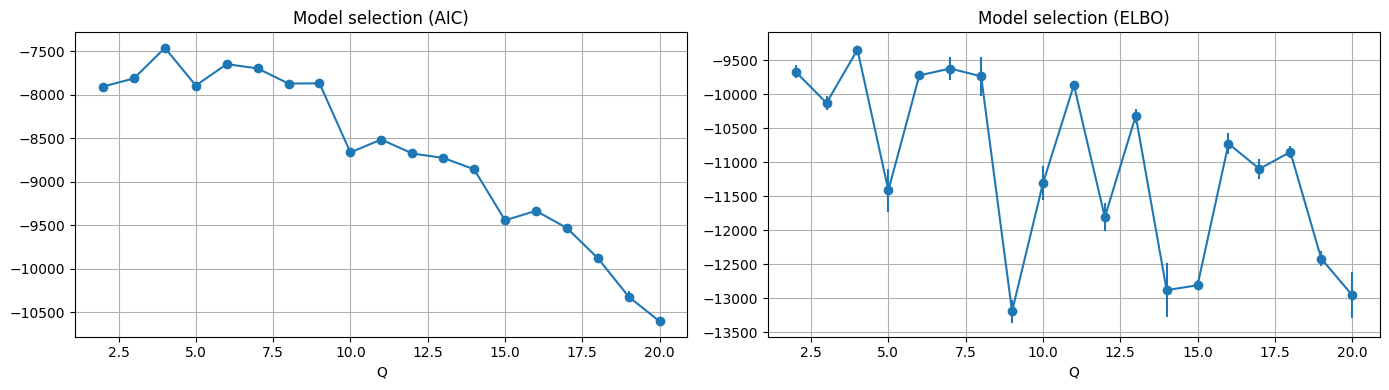

In [ ]:

ego_id = 348

A_np, circle_sets, circle_names, node_ids, id2idx = load_ego_graph_and_circles(root, ego_id)
N = A_np.shape[0]
print("N nodes:", N, "n_circles:", len(circle_sets))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Adja_matrix_tensor = torch.from_numpy(A_np).float().to(device)

#  do not need to track ARI
true_label_tensor = torch.zeros(N, dtype=torch.long, device=device)

Q_list = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

maxiter_init = 700
maxiter = 1000
n_repeat_selection = 3

model_selection_aic  = np.zeros((len(Q_list), n_repeat_selection))
model_selection_bic  = np.zeros((len(Q_list), n_repeat_selection))
model_selection_elbo = np.zeros((len(Q_list), n_repeat_selection))

best_elbo_per_q, best_aic_per_q, best_bic_per_q = [], [], []

for iq, q in enumerate(Q_list):
    print(f"Assessing DeepLPBM on Q={q} ({iq+1}/{len(Q_list)})")

    best_elbo = -np.inf
    best_aic  = -np.inf
    best_bic  = -np.inf

    for i in range(n_repeat_selection):
        torch.manual_seed(i)
        np.random.seed(i)

        model = DeepLPBM(N=N, Q=q, H=30).to(device)

        Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor, q)
        model, _, _ = pretraining(model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)
        model, _, _, _, _ = training(model, N, q, Adja_matrix_tensor, true_label_tensor, maxiter=maxiter)

        # AIC
        loglik_hat, z_map, eta_map, Pi_map, _ = model.get_map_loglikeli(Adja_matrix_tensor)

        aic = AIC_score(loglik_hat.item(), N, q)
        bic = BIC_score(loglik_hat.item(), N, q)
        model_selection_aic[iq, i] = aic
        model_selection_bic[iq, i] = bic

        # ELBO
        elbo, recon, kl = model.elbo(Adja_matrix_tensor)
        model_selection_elbo[iq, i] = elbo.item()

        if elbo.item() > best_elbo:
            best_elbo = elbo.item()
            best_aic  = aic
            best_bic  = bic

    best_elbo_per_q.append(best_elbo)
    best_aic_per_q.append(best_aic)
    best_bic_per_q.append(best_bic)

# plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].errorbar(Q_list, model_selection_aic.mean(axis=1), yerr=model_selection_aic.std(axis=1), fmt='o-')
axes[0].set_title("Model selection (AIC)")
axes[0].set_xlabel("Q"); axes[0].grid(True)

axes[1].errorbar(Q_list, model_selection_elbo.mean(axis=1), yerr=model_selection_elbo.std(axis=1), fmt='o-')
axes[1].set_title("Model selection (ELBO)")
axes[1].set_xlabel("Q"); axes[1].grid(True)


plt.tight_layout()
plt.show()


In [ ]:
N = Adja_matrix_tensor.size(0)
q = 4

true_label_tensor = torch.zeros(N, dtype=torch.long, device=device)

best_model = DeepLPBM(N=N, Q=q, H=30).to(device)

Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor, q)
best_model, _, _ = pretraining(best_model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)

best_model, _, _, _, _ = training(best_model, N, q, Adja_matrix_tensor, true_labels=true_label_tensor, maxiter=maxiter)

best_model.eval()
with torch.no_grad():
    loglik_hat, z_map, eta_hat, Pi_map, extra = best_model.get_map_loglikeli(Adja_matrix_tensor)


encoder grad mean abs: 22.540302276611328
decoder grad mean abs: 29.760944366455078


In [ ]:
#layout (TSNE/UMAP)
def get_tsne_layout(eta_hat, projector="TSNE", random_state=42, perplexity=30):
    if isinstance(eta_hat, torch.Tensor):
        eta_np = eta_hat.detach().cpu().numpy()
    else:
        eta_np = np.asarray(eta_hat)

    N = eta_np.shape[0]

    if projector == "TSNE":
        perp = min(perplexity, max(2, (N - 1) // 3))
        tsne = TSNE(n_components=2, perplexity=perp, random_state=random_state,
                    init="pca", learning_rate="auto")
        pos_2d = tsne.fit_transform(eta_np)
    elif projector == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=random_state)
        pos_2d = reducer.fit_transform(eta_np)

    mn = pos_2d.min(axis=0); mx = pos_2d.max(axis=0)
    denom = np.where((mx - mn) == 0, 1.0, (mx - mn))
    pos_2d = (pos_2d - mn) / denom
    return pos_2d  # (N,2)

# pie markers
def draw_pie_marker(ax, x, y, ratios, size=0.02, colors=None):
    start = 0.0
    for ratio, color in zip(ratios, colors):
        if ratio <= 0:
            continue
        wedge = matplotlib.patches.Wedge(
            center=(x, y), r=size,
            theta1=start * 360.0,
            theta2=(start + ratio) * 360.0,
            facecolor=color, edgecolor="black", linewidth=0.4
        )
        ax.add_patch(wedge)
        start += ratio


In [ ]:
def circles_to_eta(circle_sets, circle_names, N, K=10, zero_policy="zeros"):
    idx = np.argsort([len(s) for s in circle_sets])[::-1]
    idx = idx[:min(K, len(idx))]

    chosen_sets  = [circle_sets[i] for i in idx]
    chosen_names = [circle_names[i] for i in idx] if circle_names else [f"circle_{i}" for i in idx]
    Q = len(chosen_sets)

    eta_raw = np.zeros((N, Q), dtype=float)
    for q, s in enumerate(chosen_sets):
        eta_raw[list(s), q] = 1.0

    row_sum = eta_raw.sum(axis=1, keepdims=True)

    if zero_policy == "uniform":
        eta = np.where(row_sum > 0, eta_raw / row_sum, 1.0 / max(Q, 1))
    else:  # "zeros"
        eta = np.where(row_sum > 0, eta_raw / row_sum, 0.0)

    return eta.astype(np.float32), chosen_names

def visualize_network_with_membership(A_tensor, eta_tensor_or_np, layout_pos,
                                      title="", legend_labels=None,
                                      draw_edges=True, max_edges=20000):
    A_np = A_tensor.detach().cpu().numpy()
    if isinstance(eta_tensor_or_np, torch.Tensor):
        eta_np = eta_tensor_or_np.detach().cpu().numpy()
    else:
        eta_np = np.asarray(eta_tensor_or_np)

    N, Q = eta_np.shape

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect("equal")
    ax.axis("off")

    # edges
    if draw_edges:
        G = nx.from_numpy_array(A_np)
        if G.number_of_edges() > max_edges:
            edges = list(G.edges())
            keep = np.random.choice(len(edges), size=max_edges, replace=False)
            H = nx.Graph()
            H.add_nodes_from(G.nodes())
            H.add_edges_from([edges[k] for k in keep])
            G = H

        pos_dict = {i: layout_pos[i] for i in range(N)}
        nx.draw_networkx_edges(G, pos_dict, ax=ax, alpha=0.08, edge_color="gray")

    # node pies
    cmap = plt.cm.get_cmap("tab20", Q) if Q > 10 else plt.cm.get_cmap("tab10", Q)
    colors = [cmap(i) for i in range(Q)]
    pie_size = 0.02 if N < 200 else 0.01

    for i in range(N):
      x, y = layout_pos[i]
      ratios = eta_np[i]
      if ratios.sum() <= 1e-12:
          ax.add_patch(matplotlib.patches.Circle((x, y), radius=pie_size, facecolor="lightgray",
                                                edgecolor="black", linewidth=0.4))
      else:
          draw_pie_marker(ax, x, y, ratios, size=pie_size, colors=colors)


    # legend
    if legend_labels is None:
        legend_labels = [f"Cluster {i+1}" for i in range(Q)]
    legend_elements = [
        matplotlib.patches.Patch(facecolor=colors[i], edgecolor="k", label=str(legend_labels[i]))
        for i in range(Q)
    ]
    ax.legend(handles=legend_elements, loc="upper right", title="Communities")

    plt.title(title)
    plt.show()


/tmp/ipython-input-1049004478.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", Q) if Q > 10 else plt.cm.get_cmap("tab10", Q)


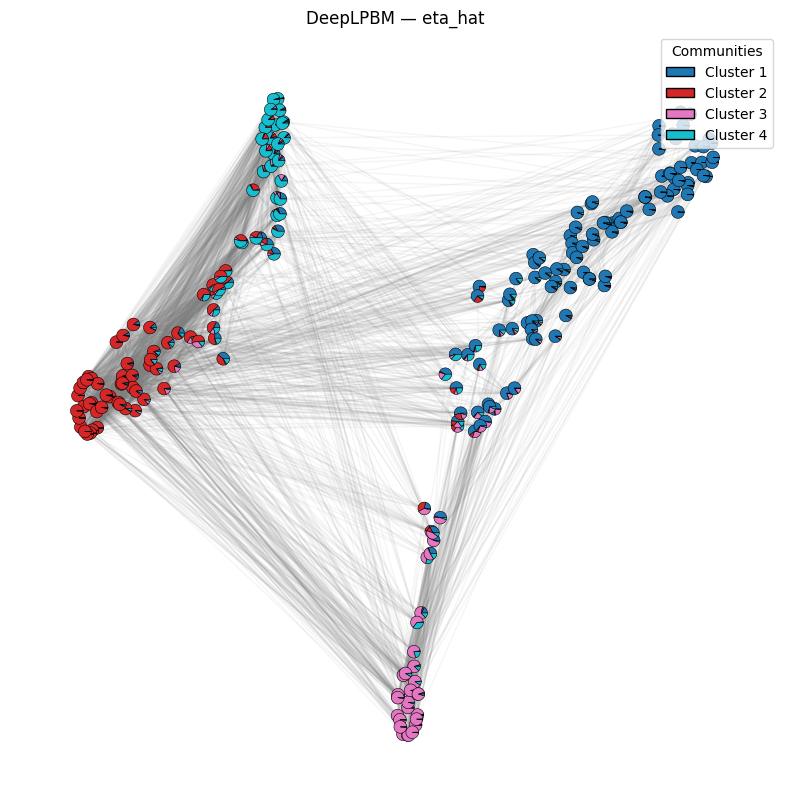

/tmp/ipython-input-1049004478.py:18: RuntimeWarning: invalid value encountered in divide
  eta = np.where(row_sum > 0, eta_raw / row_sum, 0.0)


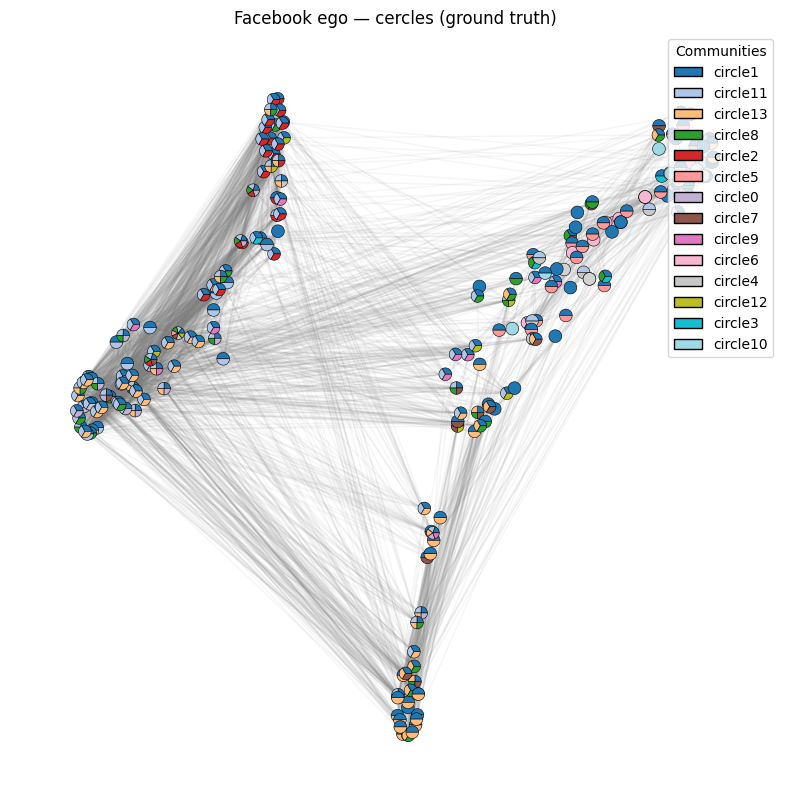

In [ ]:
#fix layout
layout_pos = get_tsne_layout(eta_hat, projector="TSNE")

#plot pred (η_hat)
visualize_network_with_membership(
    Adja_matrix_tensor, eta_hat, layout_pos,
    title="DeepLPBM — eta_hat",
    draw_edges=True
)

#plot "ground truth circles"
N = Adja_matrix_tensor.size(0)
eta_circles_np, chosen_names = circles_to_eta(circle_sets, circle_names, N, K=20)

visualize_network_with_membership(
    Adja_matrix_tensor, eta_circles_np, layout_pos,
    title="Facebook ego — cercles (ground truth)",
    legend_labels=chosen_names,
    draw_edges=True
)
